In [1]:
%pip install tqdm
%pip install numpy
%pip install pandas
%pip install gymnasium
%pip install torch
%pip install matplotlib
%pip install seaborn
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!nvidia-smi

Mon Nov 25 20:46:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 2000 Ada Gene...    On  |   00000000:82:00.0 Off |                  Off |
| 30%   25C    P8              7W /   70W |       2MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tools.scopa_env import *
from tools.scopone_scientifico_sim import *
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

print(f'Playing on {device}')

Playing on cuda


In [5]:
env = ScopaEnv()

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        print(f'Creating DQN with {n_observations} observations and {n_actions} actions')
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = 40
# Get the number of state observations
state = env.reset()
state = state.flatten()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, player):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    pred = []
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            pred = policy_net(state.flatten()).detach().cpu().numpy()
    else:
        pred = env.action_space.sample()[0]

    
    actionset = pd.DataFrame(np.array(pred))
    actionset = actionset.sort_values(by=0, ascending=True)

    return actionset

    


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Creating DQN with 120 observations and 40 actions


Creating DQN with 120 observations and 40 actions


In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    #print(f'state_batch: {state_batch.shape}, action_batch: {action_batch.shape}, reward_batch: {reward_batch.shape}')

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch.view(BATCH_SIZE, n_actions))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(-1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Episodes: 100%|██████████| 1000/1000 [01:58<00:00,  8.45it/s]

Complete


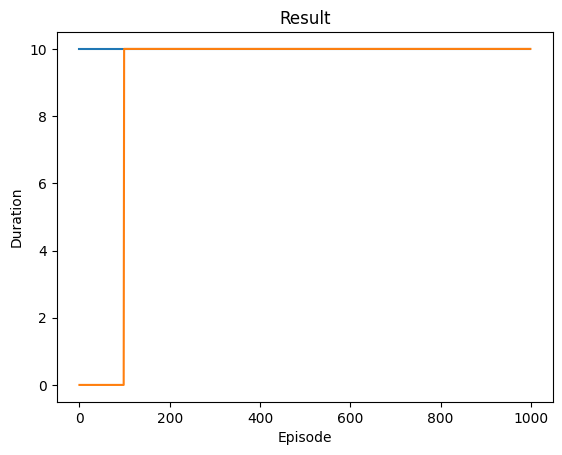

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 10

scores = []

for i_episode in tqdm(range(num_episodes), desc='Episodes'):
    # Initialize the environment and get its state
    state = env.reset()
    player = env.player
    done = False
    #print(F'Player {player.__hash__()}')
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        action = select_action(state, player)
        for i in range(0,len(action.index)):
            if env.action_valid(action.index[i], player):
                selected_action = action.index[i]
                break
            
        if selected_action is None:
            raise Exception(f'No valid action found. {action} | {[env.game.map_card_index(card) for card in player.hand]}')
        observation, reward, done, _ = env.step(selected_action, player=player, v=0)
        #print(f'state{state} action {action} observation {observation.shape} reward{reward} terminated{done}')
        reward = torch.tensor([reward], device=device)
        
        if done:
            scores.append(env.game.match_points)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


        # Store the transition in memory
        memory.push(state, torch.tensor(action.index, dtype=torch.int64, device=device), next_state if next_state is not None else None, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

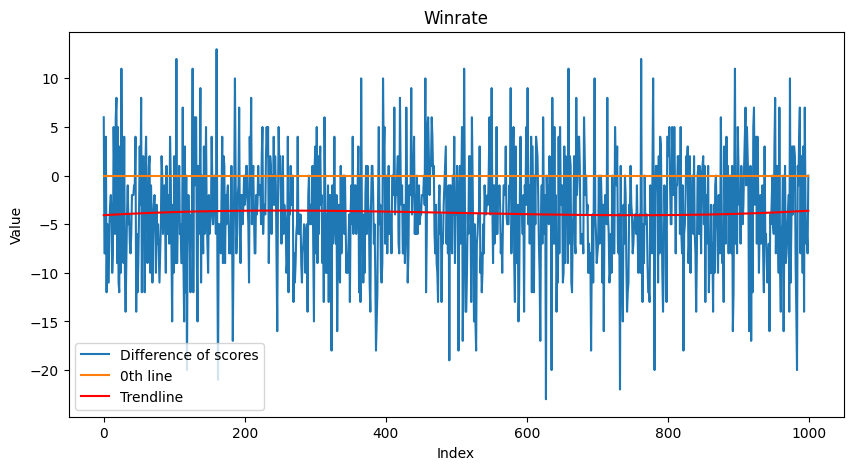

In [14]:
# Convert the scores list to a numpy array for easier manipulation
scores_array = np.array(scores)

# Calculate the difference of scores
score_diff = scores_array[:, 0] - scores_array[:, 1]

# Fit a polynomial of degree 1 (linear) to the data
z = np.polyfit(range(len(score_diff)), score_diff, 3)
p = np.poly1d(z)

# Plot the two lines
plt.figure(figsize=(10, 5))
plt.plot(score_diff, label='Difference of scores')
plt.plot(np.linspace(0, 0, len(score_diff)), label='0th line')
plt.plot(range(len(score_diff)), p(range(len(score_diff))), label='Trendline', linestyle='-', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Winrate')
plt.legend()
plt.show()

In [13]:
scores_array

array([[7, 1],
       [1, 9],
       [0, 8],
       ...,
       [1, 7],
       [1, 9],
       [3, 3]])